In [1]:
%matplotlib inline

import jax.numpy as jnp
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import seaborn as snb
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

z=1
# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


In [2]:
# load data from disk
data = jnp.load("./data_exercise5b.npz")
X = data["day"]
y = jnp.log(data["bike_count"])
# remove mean and scale to unit variance
ym, ys = jnp.mean(y), jnp.std(y)
y = (y-ym)/ys

N = jnp.shape(X)[0]

In [4]:
# Normal distribution
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))

# Half-normal distribution
log_half_npdf = lambda x, m, v: jnp.log(2) -0.5*(x-m)**2/(v) - 0.5*jnp.log(2*jnp.pi*v)
half_npdf = lambda x, m, v: jnp.exp(log_half_npdf(x, m, v))

# in the code below tau represents the distance between to input points, i.e. tau = ||x_n - x_m||.
def squared_exponential(tau, kappa, lengthscale):
    return kappa**2*jnp.exp(-0.5*tau**2/lengthscale**2)

def log_halfnormal(x):
    return jnp.log(2) + jnp.norm.logpdf(x, 0, 1)


def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)
    
    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = random.multivariate_normal(key_proposal, mean=theta_cur, cov=tau)
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))
        
        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)
            
        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))
        
    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas, accepts

def metropolis_multiple_chains(log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up=0):
    """ Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (jnp.array with shape (num_chains, num_params))        
        seeds:              seed for each chain (jnp.array with shape (num_chains))
        warm_up:            number of warm up samples to be discarded
    
    returns:
        thetas              jnp.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        jnp.array of acceptances rate for each chain (shapes: num_chains)
    
     """
    
    # verify dimension of initial parameters 
    assert theta_init.shape == (num_chains, num_params), "theta_init seems to have the wrong dimensions. Plaese check your code."

    ##############################################
    # Your solution goes here
    ##############################################
    
    # prepare arrays for storing samples
    thetas = []
    accept_rates = []    

    # run sampler for each chain
    for idx_chain in range(num_chains):
        print(f'Running chain {idx_chain}. ', end='')
        thetas_temp, accepts_temp = metropolis(log_target, num_params, tau, num_iter, theta_init=theta_init[idx_chain], seed=seeds[idx_chain])
        thetas.append(thetas_temp)
        accept_rates.append(jnp.array(accepts_temp))

    thetas = jnp.stack(thetas, axis=0)
    accept_rates = jnp.stack(accept_rates, axis=0)

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]
    
    ##############################################
    # End of solution
    ##############################################

    # verify dimensions and return
    assert thetas.shape == (num_chains, num_iter+1-warm_up, num_params), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates


In [5]:
class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1., lengthscale=1.0):
        """
            the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g. 
            squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None, jitter=1e-8):
        """ compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun
    
        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar
        
        returns
            K               -- NxM matrix    
        """

        # extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale

        ##############################################
        # Your solution goes here
        ##############################################
        
        # compute all the pairwise distances efficiently
        dists = jnp.sqrt(jnp.sum((jnp.expand_dims(X1, 1) - jnp.expand_dims(X2, 0))**2, axis=-1))
        
        # squared exponential covariance function
        K = self.kernel_fun(dists, kappa, lengthscale)
        
        # add jitter to diagonal for numerical stability
        if len(X1) == len(X2) and jnp.allclose(X1, X2):
            K = K + jitter*jnp.identity(len(X1))
        
        ##############################################
        # End of solution
        ##############################################
        
        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K

In [6]:

def log_marginal_likelihood(K, sigma, y):
    
    # Cholesky Decomposition
    C = K + sigma ** 2 * jnp.identity(N)
    
    L = jnp.linalg.cholesky(C)
    v = jnp.linalg.solve(L, y)
    
    logdet_term = jnp.sum(jnp.log(jnp.diag(L)))
    quad_term =  0.5*jnp.sum(v**2)
    const_term = -0.5*N*jnp.log(2*jnp.pi)
    
    return const_term - logdet_term - quad_term

# Theta is a equal to [k , l ,sigma]
def log_joint(theta):
    theta = jnp.asarray(theta)  
    if jnp.any(theta < 0):
        return -jnp.inf

    k, l, sigma = theta
    v = 38.82  # Variance for l prior
    
    
    log_prior_k = log_half_npdf(k, 0, 1)
    log_prior_sigma = log_half_npdf(sigma, 0 , 1)
    log_prior_l = log_half_npdf(l, 0, v)
    
    kernel = StationaryIsotropicKernel(kernel_fun = squared_exponential,
                                       kappa = k,
                                       lengthscale = l)
    
    K = kernel.contruct_kernel(X, X)
    
    log_likelihood = log_marginal_likelihood(K, sigma, y)
    
    
    return log_prior_k + log_prior_sigma + log_prior_l + log_likelihood


    
    
theta = [2, 2, 3]
log_joint(theta)    

Array(-804.77496331, dtype=float64)

In [7]:
Sigma = 0.5 * jnp.diag(jnp.array([1.0, 100.0, 0.01]))
num_chains = 4
num_iter = 10000
warm_up = int(0.5*num_iter)
num_params = 3
seeds = jnp.arange(num_chains)

key = random.PRNGKey(0)
theta_init = random.uniform(key, shape=(4, 3), minval=0.5, maxval=2.0)
thetas, accept_rates = metropolis_multiple_chains(
    log_target=log_joint, 
    num_params=num_params,
    num_chains= 4,
    tau= Sigma,
    num_iter=num_iter,
    theta_init=theta_init,
    seeds=seeds,
    warm_up=warm_up)




Running chain 0. Acceptance ratio: 0.07
Running chain 1. Acceptance ratio: 0.06
Running chain 2. Acceptance ratio: 0.07
Running chain 3. Acceptance ratio: 0.07


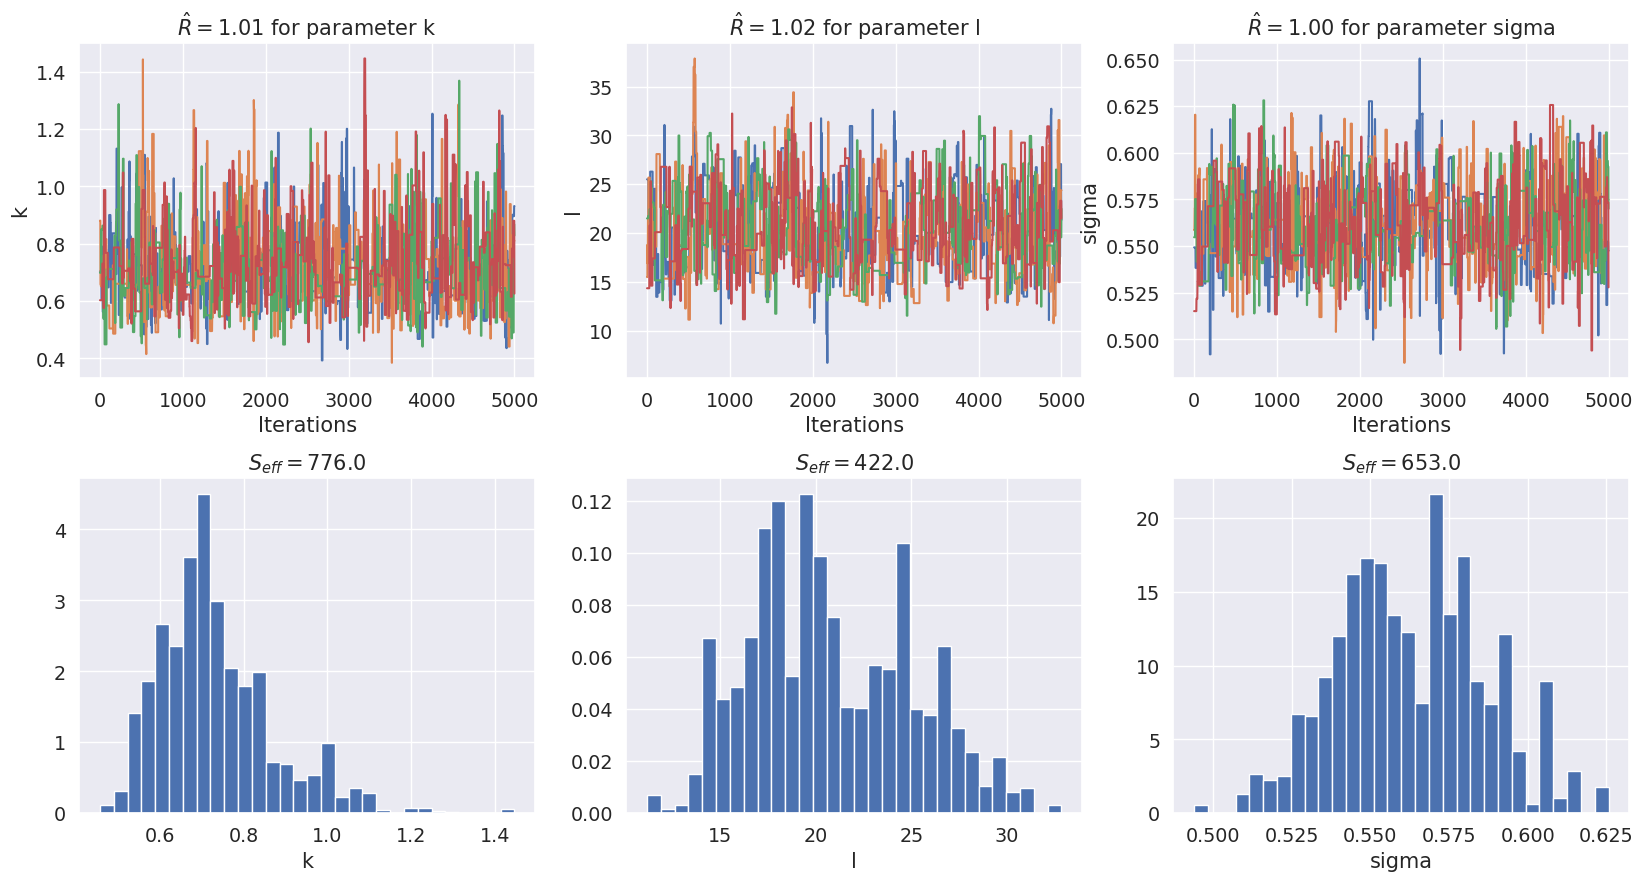

In [8]:
k_samples = thetas[:,:,0]
l_samples = thetas[:,:,1]
sigma_samples = thetas[:,:,2]

def gelman_rubin(x):
    """ Estimate the marginal posterior variance. Vectorised implementation. """
    m_chains, n_iters = x.shape

    # Calculate between-chain variance
    B_over_n = ((jnp.mean(x, axis=1) - jnp.mean(x))**2).sum() / (m_chains - 1)

    # Calculate within-chain variances
    W = ((x - x.mean(axis=1, keepdims=True))**2).sum() / (m_chains*(n_iters - 1))

    # (over) estimate of variance
    s2 = W * (n_iters - 1) / n_iters + B_over_n

    return s2

def compute_effective_sample_size_single_param(x):
    """ Compute the effective sample size of estimand of interest. Vectorised implementation. """
    m_chains, n_iters = x.shape

    variogram = lambda t: ((x[:, t:] - x[:, :(n_iters - t)])**2).sum() / (m_chains * (n_iters - t))

    post_var = gelman_rubin(x)

    t = 1
    rho = np.ones(n_iters)
    negative_autocorr = False

    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n_iters):
        rho[t] = 1 - variogram(t) / (2 * post_var)

        if not t % 2:
            negative_autocorr = sum(rho[t-1:t+1]) < 0

        t += 1

    return int(m_chains*n_iters / (1 + 2*rho[1:t].sum()))

def compute_effective_sample_size(chains_):
    """ computes the effective sample size for each parameter in a MCMC simulation. 
        The function expects the argument chain to be a numpy array of shape (num_chains x num_samples x num_params)
        and it return a numpy of shape (num_params) containing the S_eff estimates for each parameter
    """

    # force numpy
    chains = np.array(chains_)

    # get dimensions
    num_chains, num_samples, num_params = chains.shape

    # estimate sample size for each parameter
    S_eff = np.array([compute_effective_sample_size_single_param(chains[:, :, idx_param]) for idx_param in range(num_params)])

    # return
    return S_eff


def compute_Rhat(chains):
    """ Computes the Rhat convergence diagnostic for each parameter in a MCMC simulation. 
        The function expects the argument chain to be a numpy array of shape (num_chains x num_samples x num_params)
        and it return a numpy of shape (num_params) containing the Rhat estimates for each parameter
    """

    # get dimensions
    num_chains, num_samples, num_params = chains.shape

    # make subchains by splitting each chains in half
    sub_chains = []
    half_num_samples = int(0.5*num_samples)
    for idx_chain in range(num_chains):
        sub_chains.append(chains[idx_chain, :half_num_samples, :])
        sub_chains.append(chains[idx_chain, half_num_samples:, :])

    # count number of sub chains
    num_sub_chains = len(sub_chains)
        
    # compute mean and variance of each subchain
    chain_means = np.array([np.mean(s, axis=0) for s in sub_chains])                                             # dim: num_sub_chains x num_params
    chain_vars = np.array([1/(num_samples-1)*np.sum((s-m)**2, 0) for (s, m) in zip(sub_chains, chain_means)])    # dim: num_sub_chains x num_params

    # compute between chain variance
    global_mean = np.mean(chain_means, axis=0)                                                                   # dim: num_params
    B = num_samples/(num_sub_chains-1)*np.sum((chain_means - global_mean)**2, axis=0)                            # dim: num_params

    # compute within chain variance
    W = np.mean(chain_vars, 0)                                                                                   # dim: num_params                                                          

    # compute estimator and return
    var_estimator = (num_samples-1)/num_samples*W + (1/num_samples)*B                                            # dim: num_params 
    Rhat = np.sqrt(var_estimator/W)
    return Rhat

def plot_diagnostics(posterior_samples, parameter_names):

    # get dimensions
    num_chains, num_samples, num_params = posterior_samples.shape
    
    # calculate diagnostics
    Rhats = compute_Rhat(posterior_samples)
    Seff = compute_effective_sample_size(posterior_samples)
    
    # prep plot
    fig, axes = plt.subplots(2, num_params, figsize=(20, 10))
    for idx_param in range(num_params):
        for idx_chain in range(num_chains):

            # plot trace for each chain
            axes[0, idx_param].plot(posterior_samples[idx_chain, :, idx_param])

        axes[0, idx_param].set(title=f'$\\hat{{R}} = {Rhats[idx_param]:3.2f}$ for parameter {parameter_names[idx_param]}', ylabel=parameter_names[idx_param])        
        axes[0, idx_param].set_xlabel('Iterations')

        # plot histogram
        axes[1, idx_param].hist(posterior_samples[idx_chain, :, idx_param].flatten(), 30, density=True)
        axes[1, idx_param].set(title=f'$S_{{eff}}= {Seff[idx_param]:3.1f}$', xlabel=parameter_names[idx_param])

    fig.subplots_adjust(hspace=0.3)
    
# combine samples into an array of shape (num_chains, num_samples, num_params)
posterior_samples = jnp.stack((k_samples, l_samples, sigma_samples), 2)

# make list of parameter names for plotting
parameter_names = ['k', 'l', 'sigma']

plot_diagnostics(thetas, parameter_names)

In [20]:
posterior_samples_merged = posterior_samples.reshape((-1, 3))
post_std = jnp.std(posterior_samples_merged, axis=0)
S_eff = compute_effective_sample_size(posterior_samples)
MCSE = post_std / jnp.sqrt(S_eff)

for idx_param in range(3):
    print(f'{parameter_names[idx_param]}\t\tmean = {jnp.mean(posterior_samples_merged[:, idx_param]):4.3f}, \t MCSE = {MCSE[idx_param]:4.3f}')

k		mean = 0.718, 	 MCSE = 0.005
l		mean = 20.281, 	 MCSE = 0.210
sigma		mean = 0.562, 	 MCSE = 0.001


In [21]:
# compute 95% credible intervals
for idx_param in range(3):
    lower_bound = jnp.percentile(posterior_samples_merged[:, idx_param], 2.5)
    upper_bound = jnp.percentile(posterior_samples_merged[:, idx_param], 97.5)
    print(f'{parameter_names[idx_param]}\t\t95% credible interval = [{lower_bound:4.3f}, {upper_bound:4.3f}]')

k		95% credible interval = [0.504, 1.046]
l		95% credible interval = [13.391, 29.456]
sigma		95% credible interval = [0.522, 0.608]
